In [34]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xesmf import Regridder

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

In [2]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="uoo03538", cores=8, processes=8, memory="100GB", walltime="04:00:00"
)
cluster.scale(8)

from dask.distributed import Client

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.94.167:34278,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Task exception was never retrieved
future: <Task finished name='Task-32673' coro=<Client._gather.<locals>.wait() done, defined at /scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-32671' coro=<Client._gather.<locals>.wait() done, defined at /scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/distribute

### Load daily mean wind speed data

In [17]:
eroot = Path("/nesi/nobackup/uoo03538/andrew.pauling/era5")
ncu = eroot.joinpath("e5.oper.an.sfc.128_165_10u.ll025.19790101-20201231.nc")
ncv = eroot.joinpath("e5.oper.an.sfc.128_166_10v.ll025.19790101-20201231.nc")

dsu = xr.open_dataset(ncu, chunks={"time": -1, "latitude": 100, "longitude": 100})
dsv = xr.open_dataset(ncv, chunks={"time": -1, "latitude": 100, "longitude": 100})

dau = dsu["VAR_10U"].sel(latitude=slice(-20, -60), longitude=slice(145, 200))
dav = dsv["VAR_10V"].sel(latitude=slice(-20, -60), longitude=slice(145, 200))

wind_e = np.sqrt(dau**2 + dav**2).compute()

/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" start

In [21]:
mroot = Path("../data/processed/HadGEM3-GC31-LL/historical/day/sfcWind")

mfiles = sorted(list(mroot.glob("sfcWind_*.nc")))

dsm = xr.open_mfdataset(mfiles, combine="nested", concat_dim="ensmem")
dsm = dsm.chunk({"time": -1})

wind_m = dsm["sfcWind"].sel(lat=slice(-60, -20), lon=slice(145, 200)).compute()

### Compute 99th percentile wind speed

In [22]:
wind_e99 = wind_e.groupby("time.year").quantile(0.99, "time")
wind_m99 = wind_m.groupby("time.year").quantile(0.99, "time")

### Make comparison plots

In [44]:
def plotnz(axs, data, title):
    axs.coastlines()
    axs.gridlines()
    axs.set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
    im = data.plot.pcolormesh("lon", "lat", ax=axs, transform=ccrs.PlateCarree(), cbar_kwargs={"label": "U$_{99}$ [m s$^{-1}$]"})
    
    if title != "Anomaly":
        im.set_clim(4, 18)
    axs.set_title(title)
    
    return im

In [45]:
mean_e = wind_e99.mean("year").rename({"latitude": "lat", "longitude": "lon"})
mean_m = wind_m99.mean(("year", "ensmem"))

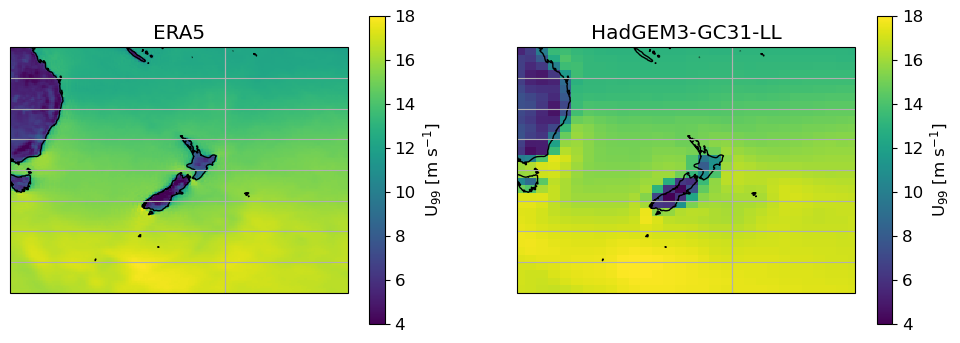

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)})

im1 = plotnz(ax1, mean_e, "ERA5")
im2 = plotnz(ax2, mean_m, "HadGEM3-GC31-LL")

In [47]:
regridder = Regridder(mean_e, mean_m, method="bilinear")
mean_e_r = regridder(mean_e)

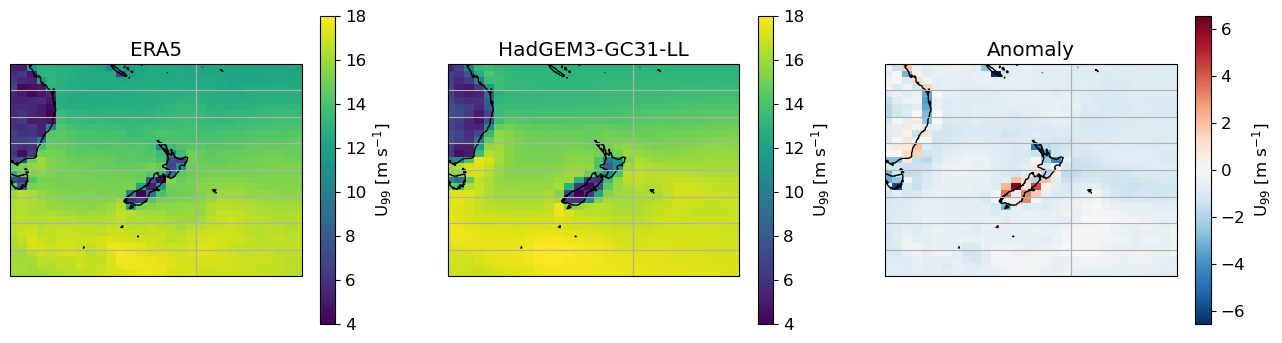

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)})

im1 = plotnz(ax1, mean_e_r, "ERA5")
im2 = plotnz(ax2, mean_m, "HadGEM3-GC31-LL")
im3 = plotnz(ax3, mean_e_r-mean_m, "Anomaly")

fig.savefig("../figures/windextremes_comparison.png", bbox_inches="tight", dpi=300)